Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [492]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [493]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [494]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [495]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [496]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [497]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

 Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
 Use scikit-learn for logistic regression.

In [498]:
# Begin with baselines for classification.
df.Great.sum()/ df.Great.shape[0]
baseline = 1- df.Great.sum()/ df.Great.shape[0]
print(df.Great.sum()/ df.Great.shape[0],'43% are rated great, or true')
print('thus the majority class baseline , is False, or not great, frequency of 58%')
print('Thus we will choose FALSE as our baseline by this method')

baseline

0.4323040380047506 43% are rated great, or true
thus the majority class baseline , is False, or not great, frequency of 58%
Thus we will choose FALSE as our baseline by this method


0.5676959619952494

In [499]:
#3way split

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
lb = pd.to_datetime('2016-12-31')
hp = pd.to_datetime('2018-01-01')

train = df[df.Date <= lb]
val  = df[df.Date.between(lb,hp, inclusive=False) ]
test = df[df.Date >= hp]


In [500]:
#clean up features: 

nnancols=df.columns[df.isnull().sum() < 300]     #all cols with not oto many nans
numcols = df.describe(include='number').columns  #all numeric cols

numcols = numcols.intersection(nnancols)         #all numeric excluding nans >300 
catcols = df.describe(exclude='number').columns

cats_hc = df[df.describe(exclude='number').columns].describe().loc['unique'] >= 15  # low cardinality will be includd
hc  = df[df.describe(exclude='number').columns].describe().loc['unique'] >= 10
hc_cols = df[catcols].columns[hc]
catcols = catcols.drop(hc_cols)


target = ['Great']

features = numcols.append(catcols).drop(target)


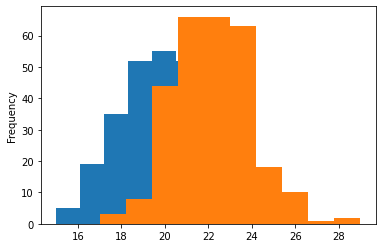

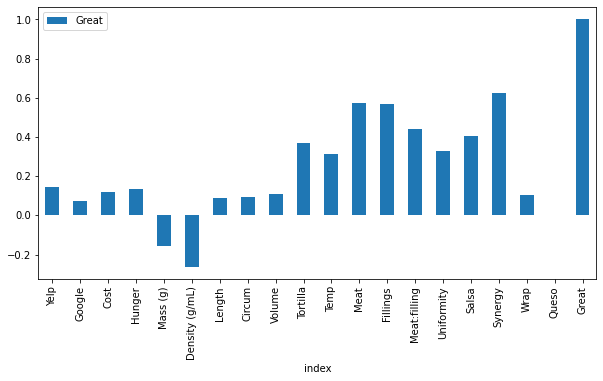

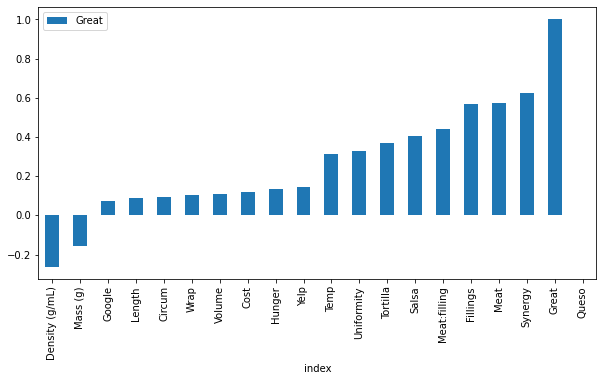

In [501]:
df[features] ##do we need to make it a list? nope indexes are cool
##check ok to impute with mean 
df.Length.describe()
df.Length.isnull().sum() #
df.Length.plot(kind='hist')
df.Circum.isnull().sum()
df.Circum.plot(kind='hist')
#yes i guess
df.corr().reset_index().plot(x='index', y=target,figsize=(10,5), kind ='bar')
df.corr().reset_index().sort_values(target).plot(x='index', y=target,figsize=(10,5), kind ='bar')

In [502]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.preprocessing import StandardScaler

#heres an evil spaghetti to test feature chosen below, plug here
#features=['Meat', 'Fillings', 'Synergy']                                     # <<= better validation acccuracy
#features=['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Synergy']  #<<== better test accuracy
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]

x_test = test[features]
y_test = test[target]


In [503]:
encoder = ce.OneHotEncoder(use_cat_names=True)

x_train_encoded = encoder.fit_transform(x_train)
x_val_encoded = encoder.transform(x_val)

x_test_encoded = encoder.transform(x_test)
#x_train_encoded = x_train_encoded[['Meat', 'Fillings', 'Synergy']]
x_train_encoded.head()


,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,...,Bacon_x,Sushi_nan,Sushi_x,Avocado_nan,Avocado_x,Corn_nan,Corn_x,Corn_X,Zucchini_nan,Zucchini_x
0,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,...,0,1,0,1,0,1,0,0,1,0
1,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,...,0,1,0,1,0,1,0,0,1,0
2,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,...,0,1,0,1,0,1,0,0,1,0
3,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,...,0,1,0,1,0,1,0,0,1,0
4,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,...,0,1,0,1,0,1,0,0,1,0


In [504]:
#impute some stuff with imputer then standardize 
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train_encoded)
x_val_imputed =  imputer.transform(x_val_encoded)      #returns array
x_test_imputed = imputer.transform(x_test_encoded)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_val_scaled = scaler.transform(x_val_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

In [505]:
from sklearn.feature_selection import RFE
X= x_train_scaled
Y= y_train

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 6)
fit = rfe.fit(X, Y.values.ravel())      #reshape array from col to row
print("Num Features: %d" % fit.n_features_)
print("Feature Ranking: %s" % fit.ranking_)
feat_selected= x_train_encoded.columns[fit.support_]
#print("Selected Features: %s" % fit.support_)
print(feat_selected)
feat_selected.tolist()

#according to this, 

Num Features: 6
Feature Ranking: [ 12  20  48 107  16   1   1   1   1   1  50  85   1  13   2  32  52  33
   5 101  92  88  34  53 105  96 102  64   9  31  29  54  55   8  39  61
  67  79  97  44   3  74  75  45  58  21  30  72  63  84  24  57   4  73
  94  81 100  76  62 106  19   6 110  65  93  17  43  18 103  42  28 104
 109 108  95  91  98  82  60  83  37   7  36  56  15  86  89  66  90  68
  99  46  10  14  47  11  22  41  23  59  40  80  87  69  35  78  77  51
  71  25  49  26  70 111 112 113  27  38]
Index(['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Synergy'], dtype='object')


['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Synergy']

In [506]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

kbsel = SelectKBest(score_func=f_classif, k=6)
xtrain_kb = kbsel.fit_transform(X, Y.values.ravel())
# summarize selected features
kbsel.get_support()
selected_names = x_train_encoded.columns[kbsel.get_support()]
selected_names


Index(['Tortilla', 'Meat', 'Fillings', 'Meat:filling', 'Salsa', 'Synergy'], dtype='object')

In [507]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
model.fit(x_train_scaled, y_train.values.ravel())
print(features)
print('baseline accuracy: ', baseline)
print('validation accuracy', accuracy_score(y_val, model.predict(x_val_scaled)))
print('test accuracy', accuracy_score(y_test, model.predict(x_test_scaled)))



Index(['Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp',
       'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
       'Wrap', 'Burrito', 'Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'],
      dtype='object')
baseline accuracy:  0.5676959619952494
validation accuracy 0.7647058823529411
test accuracy 0.7631578947368421


In [508]:
print('train Accuracy', model.score(x_train_scaled, y_train))  ##accuracy score
#just checking same thign
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_train_scaled)
accuracy_score(y_train, y_pred)

train Accuracy 0.9362416107382551


0.9362416107382551